In [1]:
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
disasters = pd.read_csv('train.csv')
stop = stopwords.words('english')

#Si no encuentra "stopwords"
#import nltk
#nltk.download('stopwords')

## Analisis de los datos

In [54]:
disasters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              7613 non-null   int64  
 1   keyword         7552 non-null   object 
 2   location        5080 non-null   object 
 3   text            7613 non-null   object 
 4   target          7613 non-null   int64  
 5   target_mean     7613 non-null   float64
 6   clean_keyword   7557 non-null   object 
 7   clean_location  5107 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 475.9+ KB


### Analizando repetidos y limpiando el set de datos 

In [43]:
def getMostFrequentValue(x):
    return x.value_counts().index[0] if len(x.value_counts()) > 0 else np.NaN

#Para todos los tweets tomamos el valor mas frecuente (o NaN si no hay valor) de las columnas keyword y location indexando por texto
disasters['clean_keyword'] = disasters.loc[:, ['text', 'keyword']].groupby(['text']).transform(getMostFrequentValue)
disasters['clean_location'] = disasters.loc[:, ['text', 'location']].groupby(['text']).transform(getMostFrequentValue)

In [26]:
#Agrego la columna target_mean la cual servira para analizar los casos en que un tweet repetido haya sido tagueado de las dos formas posibles
disasters['target_mean'] = disasters.loc[:, ['text', 'target']].groupby('text').transform('mean')

### Analizamos manualmente los casos en los cuales hay una cantidad par de tweets repetidos y la mitad es considerada desastre y la otra mitad no (24 tweets conflictivos)

In [50]:
pd.set_option('display.max_colwidth', -1)
disasters.loc[disasters['target_mean'] == 0.5, 'text']

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


610     To fight bioterrorism sir.                                                                                                       
624     To fight bioterrorism sir.                                                                                                       
630     To fight bioterrorism sir.                                                                                                       
634     To fight bioterrorism sir.                                                                                                       
1197    Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...                                             
1214    I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????                                               
1221    like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit    
1331    Mmmmmm I'm burning.... I'm

In [52]:
disasters.iloc[[610, 624, 630, 634, 1221, 1349, 4379, 4381]]['target_mean'] = 1
disasters.iloc[[1197, 1331, 1214, 1365, 1221, 1349, 4306, 4320, 4379, 4381, 5321, 5641, 6091, 6094, 6103, 6123, 6614, 6616]]['target_mean'] = 0

#1197, 1331 -> cancion The Art Of Parties de Japan: https://www.youtube.com/watch?v=nI3wvK8-D10
#1214, 1365 -> Letra de otra cancion. Tweet completo: https://twitter.com/ARCaliber/status/1189236220888567808
#1221, 1349 -> nota: https://www.loc.gov/item/2018695363/
#4306, 4320 -> Tweet contra el islam
#4379, 4381 -> Tweet en referencia al secuestrador Dan Cooper (secuestro un avion en 1971)
#5320, 5641 -> Nigerianos refugiados repatriados de Camerun
#6091, 6094, 6103, 6123 -> Traduciendo se explica
#6614, 6616 -> Tweet comparando el islam con el terrorismo

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [53]:
#Aquellos tweets repetidos que tengan un target_mean menor a 0.5 los consideraremos con target 0 (no desastres)
disasters.loc[disasters['target_mean'] < 0.5, ['target']] = 0

#Aquellos tweets repetidos que tengan un target_mean mayor a 0.5 los consideraremos con target 1 (desastres)
disasters.loc[disasters['target_mean'] > 0.5, ['target']] = 1

In [218]:
disasters.drop_duplicates(subset='text', keep='last', inplace=True)
disasters.loc[:, ['id', 'keyword', 'location', 'text', 'target']].to_csv('clean_train.csv', index=False)

### Agregamos columnas utiles para analizar el set de datos

#### Caracteristicas del texto

In [ ]:
disasters['text_word_count'] = disasters.text.str.count(' ') + 1
disasters['text_total_len'] = disasters.text.str.len()
disasters['text_stripped_len'] = disasters.text.str.replace(' ', '').str.len()
disasters['text_word_length_avg'] = disasters.text_stripped_len/disasters.text_word_count
disasters['text_without_stopwords'] = disasters['text'].apply(lambda x: " ".join([item for item in x.lower().split() if item not in stop]))

#### Hashtags

In [ ]:
def isHashtag(x):
    return x.startswith('#')

disasters['hashtags'] = disasters['text_without_stopwords'].apply(lambda x: " ".join(list(filter(isHashtag, x.split()))))
disasters['hashtags_count'] = len(disasters['hashtags'])

#### Mentions

In [ ]:
def isMention(x):
    return x.startswith('@')

disasters['mentions'] = disasters['text_without_stopwords'].apply(lambda x: " ".join(list(filter(isMention, x.split()))))
disasters['mentions_count'] = len(disasters['mentions'])

#### URLs

In [59]:
import re
#URL matcher
pattern = r'(https?://[^\s]+)'

disasters['urls'] = disasters['text'].apply(lambda x: re.findall(pattern, x))
disasters['urls_count'] = len(disasters['urls'])

In [197]:
urls = pd.DataFrame({'url': re.findall(pattern, " ".join(disasters['text']))})
urls.drop_duplicates(inplace=True)

In [198]:
disaster_urls = list(np.concatenate(disasters.loc[disasters['target'] == 1, ['urls']].apply(pd.Series).unstack().reset_index(drop=True).dropna()))
non_disaster_urls = list(np.concatenate(disasters.loc[disasters['target'] == 0, ['urls']].apply(pd.Series).unstack().reset_index(drop=True).dropna()))

In [199]:
urls['frequency_on_disasters'] = urls.url.apply(lambda x: disaster_urls.count(x))
urls['frequency_on_non_disasters'] = urls.url.apply(lambda x: non_disaster_urls.count(x))
urls['total_frequency'] = urls['frequency_on_disasters'] + urls['frequency_on_non_disasters']

### TF-IDF

In [21]:
def isValidWord(tested_string):
    for letter in tested_string.lower():
        if letter not in "abcdefghijklmnopqrstuvwxyz":
            return False
    return True

valid_words = 

tfidf_vectorizer = TfidfVectorizer(use_idf=True, vocabulary=valid_words)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(disasters['text'])

In [84]:
#for i in range(0, tfidf_vectorizer_vectors.shape[0]):
    
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
#df.loc[df['tfidf'] > 0].sort_values(by=["tfidf"],ascending=False)

In [86]:
def isValidWord(tested_string):
    for letter in tested_string.lower():
        if letter not in "abcdefghijklmnopqrstuvwxyz":
            return False
    return True

#valid_words = [c for c in dft.columns if isValidWord(c)]
#dft.loc[:, valid_words]
#dft.drop(words_to_remove, axis=1, inplace=True)
#dft.head()
df

,tfidf
00,0.0
000,0.0
0000,0.0
007npen6lg,0.0
00cy9vxeff,0.0
...,...
ûóher,0.0
ûókody,0.0
ûónegligence,0.0
ûótech,0.0


## Graficos

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func
from PIL import Image

In [310]:
def showValuesOnBars(axs, h_v="v", space=0.4, color="#000000", fontsize=12):
    def showOnSinglePlot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", color=color, fontsize=fontsize) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - 0.2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", color=color, fontsize=fontsize)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            showOnSinglePlot(ax)
    else:
        showOnSinglePlot(axs)

In [ ]:
def getMostCommonValue(x):
    return x[0]

def getMostCommonFreq(x):
    return x[1]

In [ ]:
disaster_hashtags = " ".join(disasters.loc[disasters['target'] == 1, 'hashtags'])
non_disaster_hashtags = " ".join(disasters.loc[disasters['target'] == 0, 'hashtags'])

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(13,7))
f.subplots_adjust(wspace=0)

#Hashtags comunes para los desastres
disasters_most_common_hashtags = Counter(disaster_hashtags.split()).most_common(15)
top_15_used_hashtags_in_disasters = pd.DataFrame({
            'word':list(map(getMostCommonValue, disasters_most_common_hashtags)), 
            'freq':list(map(getMostCommonFreq, disasters_most_common_hashtags))
        })

plt_top_15_used_hashtags_in_disasters = sns.barplot(x='freq', y='word', data=top_15_used_hashtags_in_disasters, orient='h', ax=axes[0],
                                                    palette=sns.cubehelix_palette(start=2.5, rot=-0.2, dark=0.3, n_colors=15, reverse=True)
                                                   )
plt_top_15_used_hashtags_in_disasters.set_xlabel('Frecuencia')
plt_top_15_used_hashtags_in_disasters.set_ylabel('Hashtag')
plt_top_15_used_hashtags_in_disasters.set(title="Tweets desastres")

plt_top_15_used_hashtags_in_disasters.invert_xaxis()

#Hashtags comunes para los no desastres
non_disasters_most_common_hashtags = Counter(non_disaster_hashtags.split()).most_common(15)
top_15_used_hashtags_in_non_disasters = pd.DataFrame({
            'word':list(map(getMostCommonValue, non_disasters_most_common_hashtags)), 
            'freq':list(map(getMostCommonFreq, non_disasters_most_common_hashtags))
        })

plt_top_15_used_hashtags_in_non_disasters = sns.barplot(x='freq', y='word', data=top_15_used_hashtags_in_non_disasters, orient='h', ax=axes[1], 
                                                    palette=sns.cubehelix_palette(start=0.75, rot=-0.2, dark=0.3, n_colors=15, reverse=True)
                                                   )
plt_top_15_used_hashtags_in_non_disasters.set_xlabel('Frecuencia')
plt_top_15_used_hashtags_in_non_disasters.set_ylabel('')
plt_top_15_used_hashtags_in_non_disasters.set(title="Tweets no-desastres")

plt_top_15_used_hashtags_in_non_disasters.set_xticks([0, 10, 20, 30, 40, 50])

plt_top_15_used_hashtags_in_non_disasters.yaxis.tick_right()

sns.despine(left=True, bottom=True)
f.suptitle('Top 15 hashtags in tweets')

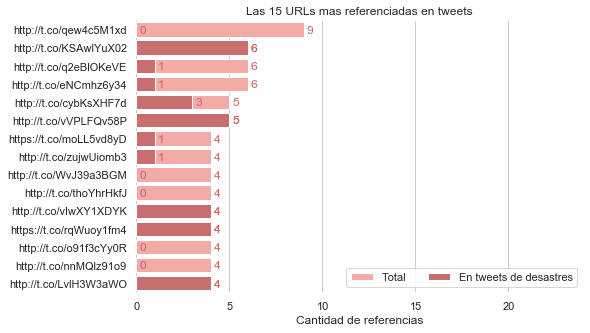

In [319]:
plot_data = urls.sort_values(by='total_frequency', ascending=False).head(15)

links_description = {
    "http://t.co/qew4c5M1xd": "Preparacion de emergencia ante un tornado",
    "http://t.co/eNCmhz6y34": "Sitio de batalla de fans (Fan Army)",
    "http://t.co/q2eBlOKeVE": "Portal billboard.com",
    "http://t.co/KSAwlYuX02": "Nota sobre una autoinmolacion de un Pakistani de 16 años",
    "http://t.co/vVPLFQv58P": "Busqueda de imagenes en Daum (Google sur-coreano) sobre el Escuadron 731",
    "http://t.co/cybKsXHF7d": "Video de la llegada de un Tsunami a EEUU",
    "http://t.co/thoYhrHkfJ": "Portal billboard.com",
    "https://t.co/rqWuoy1fm4": "Tweet contra Assad por usar bombas contra refugiados Sirios",
    "http://t.co/vIwXY1XDYK": "Sitio que fomenta contra los asesinatos masivos",
    "http://t.co/o91f3cYy0R": "Sitio de batalla de fans (Fan Army)",
    "http://t.co/LvlH3W3aWO": "Articulo sobre el miedo de los parientes de una victima de un asesinato en masa a que se repita otro",
    "http://t.co/WvJ39a3BGM": "Sitio de batalla de fans (Fan Army)",
    "https://t.co/moLL5vd8yD": "Archivo inexistente de Google",
    "http://t.co/zujwUiomb3": "Link a producto de Ebay",
    "http://t.co/nnMQlz91o9": "Portal billboard.com",
}

#urls['link_description'] = urls.url.apply(lambda x: links_description[x] if x in links_description.keys() else '')

f, ax = plt.subplots(figsize=(8, 5))
sns.set_color_codes("pastel")
tot = sns.barplot(x="total_frequency", y="url", data=plot_data, label="Total", color="r")

sns.set_color_codes("muted")
dis = sns.barplot(x="frequency_on_disasters", y="url", data=plot_data, label="En tweets de desastres", color="r")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="", xlabel="Cantidad de referencias", title="Las 15 URLs mas referenciadas en tweets")
sns.despine(left=True, bottom=True)

showValuesOnBars(tot, "h", 0.15, "r")

plt.show()

### Wordclouds

In [ ]:
disaster_mentions = " ".join(disasters.loc[disasters['target'] == 1, 'mentions'])
non_disaster_mentions = " ".join(disasters.loc[disasters['target'] == 0, 'mentions'])

In [ ]:
#Funciones de ayuda para colorear los wordcloud por clase
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [ ]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

temp_mask = np.array(Image.open("hashtag_mask.png"))
hashtag_mask = np.ndarray((temp_mask.shape[0],temp_mask.shape[1]), np.int32)

for i in range(len(temp_mask)):
    hashtag_mask[i] = list(map(transform_format, temp_mask[i]))

In [ ]:
hashtags_wc = WordCloud(font_path='BebasNeue-Regular.ttf', mask=hashtag_mask, width=1000, height=500, max_font_size=70, max_words=300, background_color="white").generate(disaster_hashtags + " " + non_disaster_hashtags)

hashtag_colors = {
    '#2D574E': list(map(lambda x: x[1:len(x)], disaster_hashtags.split())),
    '#673F59': list(map(lambda x: x[1:len(x)], non_disaster_hashtags.split()))
}

hashtags_wc.recolor(color_func=GroupedColorFunc(hashtag_colors, 'black'))

hashtags_wc.to_file("plots/hashtags_wc.png")

plt.imshow(hashtags_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
mention_mask = np.array(Image.open("twitter_mask.png"))

mentions_wc = WordCloud(font_path='BebasNeue-Regular.ttf', mask=mention_mask, width=1000, height=500, max_font_size=70, max_words=300, background_color="white").generate(disaster_mentions + " " + non_disaster_mentions)

mention_colors = {
    '#2D574E': list(map(lambda x: x[1:len(x)], disaster_mentions.split())),
    '#673F59': list(map(lambda x: x[1:len(x)], non_disaster_mentions.split()))
}

mentions_wc.recolor(color_func=GroupedColorFunc(mention_colors, 'black'))

mentions_wc.to_file("plots/mentions_wc.png")

plt.imshow(mentions_wc, interpolation='bilinear')
plt.axis("off")
plt.show()